# Trabalho Prático I - Problema de Transporte de Objeto
### Disciplina: Reinforcement Learning<br/>
Curso: Especialização em Ciência de Dados<br/>
Professor: Ricardo Grunitzki<br/>
**Aluno: Marco Antonio Batista**

---

**Descrição:**<br/>
Neste cenário, um agente deve percorrer a grade 7x6, encontrar o objeto e
transporta-lo até na base. Essa tarefa deve ser executada na menor quantidade de passos de tempo possível. O agente não possui nenhum conhecimento prévio sobre o ambiente, o qual possui paredes, as quais ele não transpor. O agente também não possui conhecimento prévio sobre a localização do objeto.<br/>
<br/>
**Observações:**<br/>
O agente possuí 33 possíveis estados.<br/>
O objeto possuí somente uma localização.<br/>
O agente agarra o objeto em 2 localizações possíveis.<br/>
O agente+objeto possuí 22 possíveis estados.<br/>
<br/>
**Ações:**<br/>
Existem 5 ações determinísticas discretas:<br/>
mover para cima;<br/>
mover para baixo;<br/>
mover para esquerda;<br/>
mover para direita;<br/>
permanecer na mesma célula;<br/>
<br/>
**Recompensas:**<br/>
Por padrão a recompensa por passo é de -1 (conforme documentação encontrada na internet) exceto quando encontrar o objeto que é +5 e quando encontrar a base que é +20.


In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 6
        self.width = 7
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # Set random start location for the agent
        #self.current_location = ( 4, np.random.randint(0,5))
        self.current_location = (5,0)
        
        # Set locations for the bomb and the gold
        self.wall_location = [(4,0),(4,1),(4,3),(4,4),(4,5),(4,6),(6,6),(1,3)]
        self.obj_location = [(2,2),(2,4)]
        self.terminal_states = [(0,2),(0,3),(0,4)]
        
        # Set grid rewards for special cells
        #self.grid[ self.wall_location[0], self.wall_location[1]] = -10
        self.grid[ self.obj_location[0], self.obj_location[1]] = 10
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

Current position of the agent = (5, 0)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = (5, 0)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


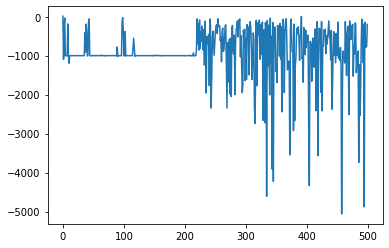

In [ ]:
env = GridWorld()
agent = Q_Agent(env)

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

# Note the learn=True argument!
reward_per_episode = play(env, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [ ]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		1.4511867721304534
	DOWN
		2.4534667685312535
	LEFT
		1.3920503778186384
	RIGHT
		-8.70055663015326
(0, 1)
	UP
		-8.660647878609618
	DOWN
		-0.007687126240403887
	LEFT
		1.34447272170054
	RIGHT
		-0.999999999999918
(0, 2)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 5)
	UP
		1.5369499113740184
	DOWN
		1.740791913843458
	LEFT
		-0.6513215599000001
	RIGHT
		7.105271541491499
(0, 6)
	UP
		7.115957215254395
	DOWN
		8.190763061937567
	LEFT
		6.045452549916688
	RIGHT
		7.1890690676010305
(1, 0)
	UP
		1.396823453111633
	DOWN
		3.553117928791125
	LEFT
		0.8028162450283387
	RIGHT
		-0.46194010863492757
(1, 1)
	UP
		-8.708507373115816
	DOWN
		0.9924885088369749
	LEFT
		-0.12663391098426624
	RIGHT
		-0.8332281830033343
(1, 2)
	UP
		-0.34390000000000004
	DOWN
		0
	LEFT
		-0.7458134171671
	RIGHT
		-0.8332281830033343
(1, 3)
	UP
		0
	DOWN
		0
	LEFT
		-0.7941088679053511
	RIGHT
		0.0109466933630192
